**Численные методы. Определение стоимости автомобилей**
_____
**Описание исследования.**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
    
_____
**Цель исследования.**

Построить модель, которая умеет определять рыночную стоимость автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Задачи исследования.**

- Загрузите данные
- Изучить и предобработать данные.
- Подготовить выборки для обучения моделей.
- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг.
- Анализ времени обучения, времени предсказания и качества моделей.
- Опираясь на критерии заказчика, выберать лучшую модель, проверив её качество на тестовой выборке.
_____
**Исходные данные.**

Файл *autos.csv* содержит данные о технических характеристиках, комплектации и ценах других автомобилей.

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
* Price — цена (евро). *Целевой признак*

_____
**Содержание проекта.**

***Шаг 1. Загрузка данных:***
* [Загрузка библиотек.](#1-bullet)
* [Изученеие файла с данными, получение общей информации.](#2-bullet)

***Шаг 2. Предобработка данных:***
* [Переименование](#3-bullet)
* [Поиск и устранение пропусков, дублей](#4-bullet)
* [Гистограмма и ящик для количественных данных](#5-bullet)
* [Оценка категориальных значени](#6-bullet)
* [Изменение данных на основе анализа](#7-bullet)

***Шаг 3. Подготовка выборок для обучения моделей:***
* [Построение корреляционной матрицы](#8-bullet)
* [Построение пайплайна предобработки](#9-bullet)

***Шаг 4. Обучение моделей***
* [Определение параметров моделей](#10-bullet)
* [Функция для обучения моделей](#11-bullet)
* [Обучение](#12-bullet)

***Шаг 5. Выбор лучшей модели***
* [Результаты](#13-bullet)
* [Тестирование](#14-bullet)

***Шаг 6. Общий вывод***


##Шаг 1. Загрузка данных:

### Загрузка библиотек
<a id='1-bullet'></a>

In [1]:
#Установка нужных бибилотек
import sys
!"{sys.executable}" -m pip install phik -q
!"{sys.executable}" -m pip install shap -q
!"{sys.executable}" -m pip install catboost
!"{sys.executable}" -m pip install category-encoders

#Импорты базовых бибоиртек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import os
import re
import math
import time


from scipy import stats

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from category_encoders import TargetEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, r2_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from warnings import simplefilter

from phik import phik_matrix
from phik.report import plot_correlation_matrix


simplefilter(action='ignore', category=FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.7 MB/s eta 0:00:00


### Изученеие файла с данными, получение общей информации
<a id='2-bullet'></a>

In [2]:
paths = [
    '/content',
    '/datasets',
    '/Users/admin/data'
]

for path in paths:
    file_path = f'{path}/autos.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, sep=',')
        break

display(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25129 entries, 0 to 25128
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DateCrawled        25129 non-null  object 
 1   Price              25128 non-null  float64
 2   VehicleType        22413 non-null  object 
 3   RegistrationYear   25128 non-null  float64
 4   Gearbox            23745 non-null  object 
 5   Power              25128 non-null  float64
 6   Model              23772 non-null  object 
 7   Kilometer          25128 non-null  float64
 8   RegistrationMonth  25128 non-null  float64
 9   FuelType           22746 non-null  object 
 10  Brand              25128 non-null  object 
 11  Repaired           20069 non-null  object 
 12  DateCreated        25128 non-null  object 
 13  NumberOfPictures   25128 non-null  float64
 14  PostalCode         25128 non-null  float64
 15  LastSeen           25128 non-null  object 
dtypes: float64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480.0,NaN,1993.0,manual,0.0,golf,150000.0,0.0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0.0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300.0,coupe,2011.0,manual,190.0,NaN,125000.0,5.0,gasoline,audi,yes,2016-03-24 00:00:00,0.0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800.0,suv,2004.0,auto,163.0,grand,125000.0,8.0,gasoline,jeep,NaN,2016-03-14 00:00:00,0.0,90480.0,2016-04-05 12:47:46


<b>Выводы:</b>

- Не все данные в столбцах соответствуют своим типам

- Названия столбцов не в "змеином" стиле

- Присутствуют пропуски в данных

- Данные о пользователе (почт.индекс и дата активности) предварительно кажутся малоинформативными для формирования цены

- Дальнейший анализ и предобработка в следующих шагах


##Шаг 2. Предобработка данных

### Переименование
<a id='3-bullet'></a>

In [3]:
#Функция для перименования
def to_snake_case(col_name):
    return ''.join(['_' + char.lower() if char.isupper() else char for char in col_name]).strip('_')

df.columns = [to_snake_case(col) for col in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [4]:
#Приведение к форматуц времени
date_col = ['date_crawled', 'last_seen', 'date_created']

df[date_col] = df[date_col].apply(pd.to_datetime, errors='coerce')

### Поиск и устранение пропусков, дублей
<a id='4-bullet'></a>

In [5]:
#Функция для отбора категорий в списки
def select_type_list(df, column_type):
    return df.select_dtypes(include=column_type).columns.tolist()

#Создание списка категориальных столбцов
cat = select_type_list(df, ['object'])

#Функция по поиску дублей
def analyze_df(df, categorical_traits):

    print('Количество пропусков в солбцах:')
    display(df.isna().mean() * 100)

    print('Количество дубликатов в столбцах:')
    display(df.apply(lambda col: col.duplicated().sum()))

    print('Количество дубликатов в строках:')
    display(df.duplicated().sum())

    for trait in categorical_traits:
        print(f"Уникальные значения для {trait}: {df[trait].unique()}")


display(analyze_df(df, cat))

Количество пропусков в солбцах:


,0
date_crawled,0.000000
price,0.003979
vehicle_type,10.808230
registration_year,0.003979
gearbox,5.507581
power,0.003979
model,5.400135
kilometer,0.003979
registration_month,0.003979
fuel_type,9.483067


Количество дубликатов в столбцах:


,0
date_crawled,457
price,23777
vehicle_type,25120
registration_year,25049
gearbox,25126
power,24794
model,24891
kilometer,25115
registration_month,25115
fuel_type,25121


Количество дубликатов в строках:


np.int64(0)

Уникальные значения для vehicle_type: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения для gearbox: ['manual' 'auto' nan]
Уникальные значения для model: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' '

None

In [6]:
#Переименование смежных названий
df['fuel_type'] = df['fuel_type'].replace('gasoline','petrol')

#Заполнение пропусков в категориальных значениях модой
for col in df[cat]:
  df[col].fillna(df[col].mode()[0], inplace=True)

display(len(df))
#Удаление дублей
df = df.drop_duplicates()

#Проверка
display(df.duplicated().value_counts())
display(len(df))

25129

,count
False,25129


25129

### Гистограмма и ящик для количественных данных
<a id='5-bullet'></a>

In [7]:
plt.style.use('Solarize_Light2')

#Создаю список интервальных значений
int_col = select_type_list(df, ['int'])

for sign in int_col:
    plt.figure(figsize=(8,  3))

    #Гистограмма
    plt.subplot(1,  2,  1)
    sns.histplot(df[sign], kde=True, color='green', edgecolor='blue', bins=50)
    plt.title(f'Распределение {sign}')

    #Построение ящика
    plt.subplot(1,  2,  2)
    sns.boxplot(df[sign], orient="h")
    plt.setp(plt.gca(),  'yticklabels', [])

    plt.show()
    display(df[sign].describe())


### Оценка категориальных значений
<a id='6-bullet'></a>

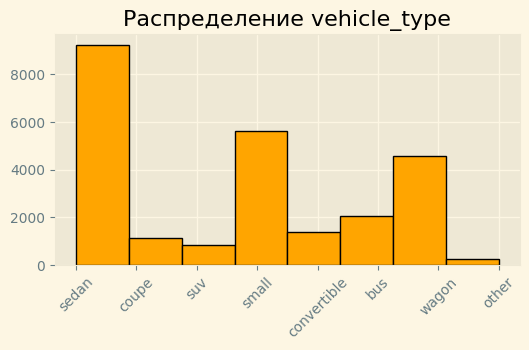

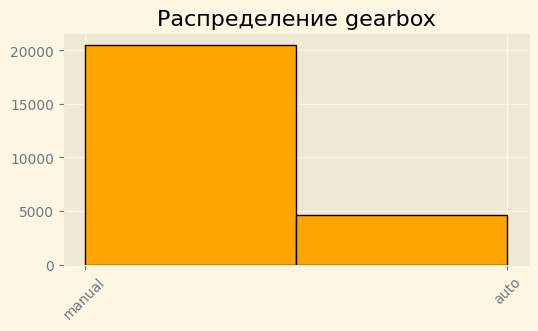

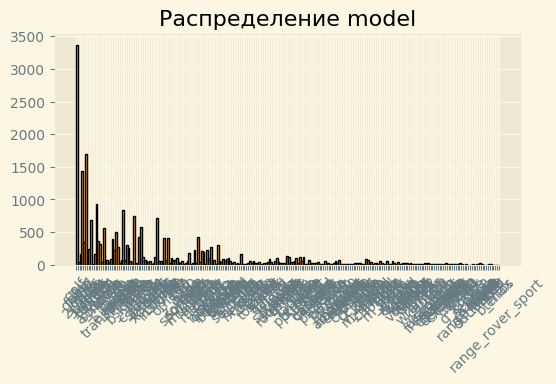

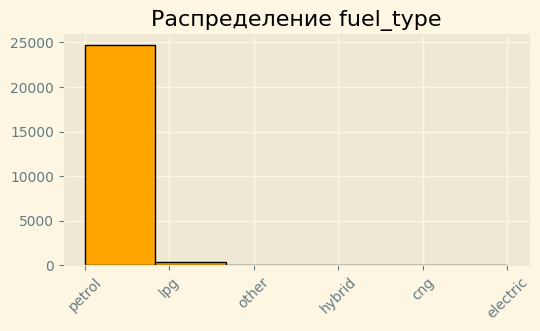

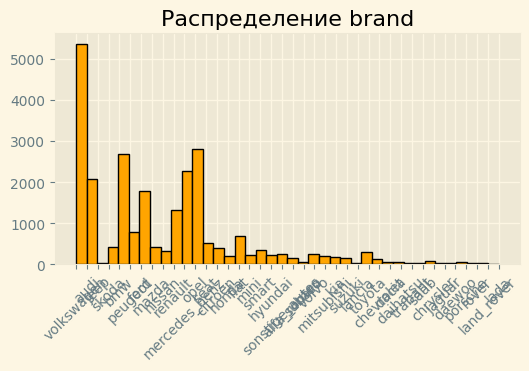

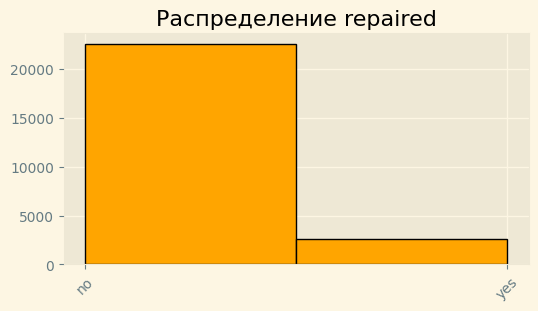

In [8]:
#Функция для визуализации категориальных значений
for sign in cat:
    unique_values = df[sign].unique()
    num_bins = len(unique_values)

    plt.figure(figsize=(6,  3))
    plt.hist(df[sign], bins=num_bins, align='mid', edgecolor='black', color='orange')
    plt.xticks(range(num_bins), unique_values, rotation=45)
    plt.title(f'Распределение {sign}')
    plt.show()

<b>Комментарий к исследовательскому анализу</b>

- В столбце цены много нулевых значений, удалим их. Так-же присутствуют в диапазоне 130к+ выбросы

- Год регистрации следует урезать в диапазонах

- Стоит убрать нулевую мощность, максимальная мощность автомобиля на сенгодняшний день около 2к л.с, остальлное удалю

- Киллометраж хоть и имеет смещения, но это нормально (допускаю что он может быть мал)

- Фича о количестве фотографий авто имея одно значение является неинформативной

- Заметен явный дисбаланс классов в категориальных данных




In [9]:
df['date_created'].describe()

,date_created
count,25128
mean,2016-03-20 22:14:16.160458496
min,2015-03-20 00:00:00
25%,2016-03-13 00:00:00
50%,2016-03-21 00:00:00
75%,2016-03-29 00:00:00
max,2016-04-07 00:00:00


### Изменение данных на основе анализа
<a id='7-bullet'></a>

In [10]:
#Список столбцов для удаления
incoming_signs = ['number_of_pictures', 'postal_code']

df = df.drop(incoming_signs, axis=1)
int_col = select_type_list(df, ['int'])

#Функция-фильтр для 0
def filter_dataframe(df, columns):
    return df[~df[columns].eq(0).any(axis=1)]

df_fil = [col for col in df.columns if col != 'power']

df = filter_dataframe(df, df_fil)

#Устранение выбросов и аномалий
df = df.loc[df['price'] > 5]
df = df.loc[df['power'] < 2000]
df = df.query(f'registration_year >= {1980} and registration_year <= {2016}')


##Шаг 3. Подготовка выборок для обучения моделей

In [11]:
#Создание нового признака
cat_ranges = {
    'Rare': (2011, 2016),
    'Medium rare': (2005, 2011),
    'Medium': (1995, 2005),
    'Well Done': (1980, 1995)
}

def categorize_reg(year):
    for category, (min_year, max_year) in cat_ranges.items():
        if min_year <= year <= max_year:
          return category

df['reg_cat'] = df['registration_year'].apply(categorize_reg)



### Построение корреляционной матрицы
<a id='8-bullet'></a>

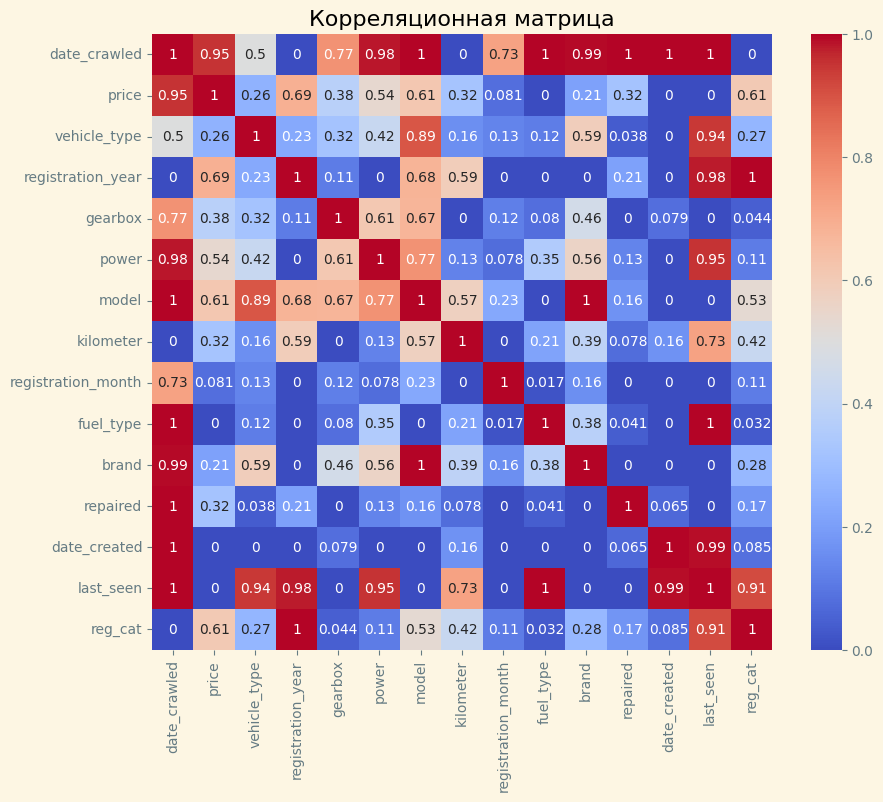

In [12]:
#Построение кор. матрицы
plt.figure(figsize=(10, 8));
sns.heatmap(df.sample(1000).phik_matrix(interval_cols=['kilometer', 'price', 'power']), annot=True, cmap='coolwarm');
plt.title('Корреляционная матрица');
plt.show();

<b>Комментарий к корреляционной матрице</b>

Признаки свзанные с датой регистрации пользователя и создания анкеты, а также последняя активность пользователя практически не оказывают влияние на цену, удалю эти признаки

In [21]:
#Списко для удаления
incoming_signs = ['date_crawled', 'last_seen', 'registration_month', 'date_created']

df = df.drop(incoming_signs, axis=1)

#Обновление колич. и категориальных признаков
int_col = select_type_list(df, ['int','float'])
int_col.remove('price')
cat = select_type_list(df, ['object'])

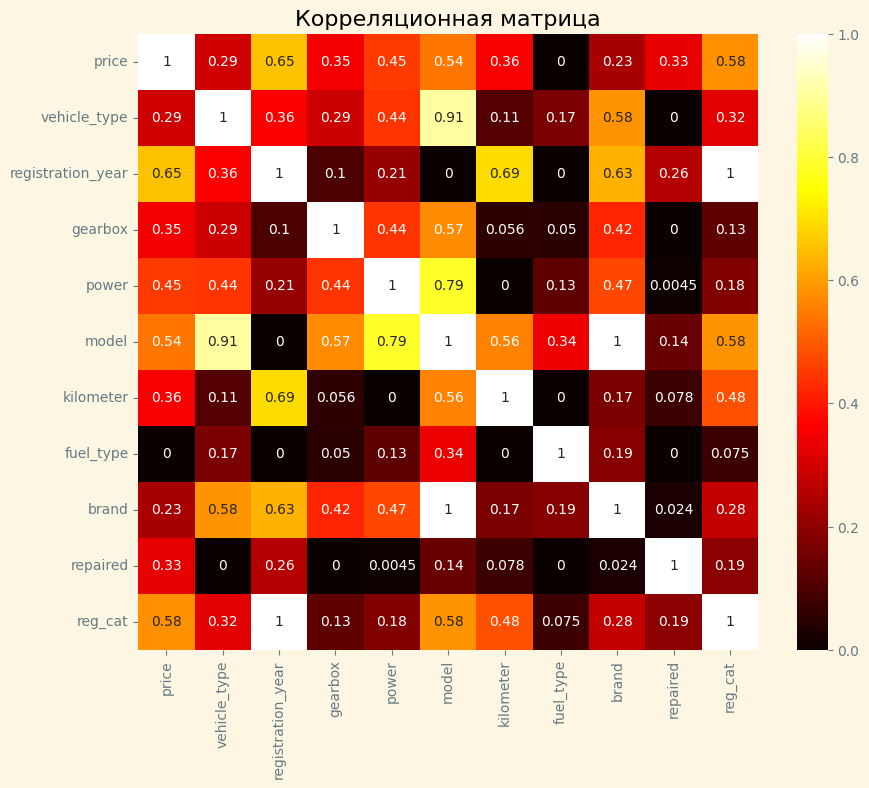

In [22]:
#Построение кор. матрицы с новыми признаками
plt.figure(figsize=(10, 8));
sns.heatmap(df.sample(1000).phik_matrix(interval_cols=['kilometer', 'price', 'power']), annot=True, cmap='hot');
plt.title('Корреляционная матрица');
plt.show();

### Построение пайплайна предобработки
<a id='9-bullet'></a>

In [23]:
#Функция для отбора уникальных значений и последующего кодирования
def uni_val(df, columns):
    result = {}
    for column in columns:
        if column in df.columns:
            df[column] = df[column].fillna('Unknown')
            result[f'unique_{column}'] = df[column].unique().tolist()
    return result

ca_di = uni_val(df, cat)

categories = []
for category_name, category_values in ca_di.items():
    categories.append(category_values)

In [24]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

#Разбивка данных
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['price'], axis=1),
    df['price'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)


#Пайплайны предобрадотки
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=categories,
                               handle_unknown='use_encoded_value', unknown_value=-1))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, int_col),
        ('cat', categorical_transformer, cat)
    ]
)

##Шаг 4. Обучение моделей

### Определение параметров моделей
<a id='10-bullet'></a>

In [25]:
#Создание словаря для каждой модели
param_grid_lightgbm = {
    'model__n_estimators': range(50, 251, 50),
    'model__max_depth': range(2, 16, 2),
    'model__num_leaves': range(15, 121, 15),
    'model__verbose': [-1]
}

param_grid_catboost = {
    'model__iterations': range(50, 201, 50),
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': range(2, 11, 2),
    'model__verbose': [False]
}

param_grid_linearregression = {
    'model__fit_intercept': [True, False],
    'model__copy_X': [True, False]
}

param_grid_randomforest = {
    'model__n_estimators': [10, 40, 70],
    'model__max_depth': [10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

### Функция для обучения моделей
<a id='11-bullet'></a>

In [26]:
def train_model(model_class, param_grid, X_train, y_train):
    #Финальный пайплан
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_class())
    ])

    #Случайный подбор
    randomized_search = RandomizedSearchCV(
        pipe,
        param_grid,
        cv=6,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )

    randomized_search.fit(X_train, y_train)

    res = randomized_search.cv_results_

    best_model = randomized_search.best_estimator_.steps[-1][1]

    return res, best_model

### Обучение
<a id='12-bullet'></a>

In [27]:
models = [
    ('LinearRegression', LinearRegression),
    ('RandomForest', RandomForestRegressor),
    ('LightGBM', LGBMRegressor),
    ('CatBoost', CatBoostRegressor)
]

results = {}
best_models = {}

#Цикл обучения
for model_name, model_class in models:
    #Подбор кодирования
    if model_name.lower() in ['linearregression']:
        categorical_transformer.steps[-1] = ('encoder', TargetEncoder())
    else:
        categorical_transformer.steps[-1] = ('encoder', OrdinalEncoder(categories=categories,
                                                                       handle_unknown='use_encoded_value', unknown_value=-1))

    model_results, best_model = train_model(model_class, eval(f'param_grid_{model_name.lower()}'), X_train, y_train)

    results[model_name] = model_results
    best_models[model_name] = best_model

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


##Шаг 5. Выбор лучшей модели

### Результаты
<a id='13-bullet'></a>

In [28]:
#Функция для вывода лучших метрик по результатам обучения
def get_best_model_performance(results):
    best_times = {}
    best_score_times = {}
    best_scores = {}

    for model_name, model_results in results.items():
        mean_fit_times = model_results['mean_fit_time']
        mean_score_times = model_results['mean_score_time']
        mean_test_scores = model_results['mean_test_score']

        #Индекс лучшей модели
        best_index = np.argmin(mean_test_scores)

        #Лучшие значения
        best_time = mean_fit_times[best_index]
        best_score_time = mean_score_times[best_index]
        best_score = mean_test_scores[best_index]

        best_times[model_name] = best_time
        best_score_times[model_name] = best_score_time
        best_scores[model_name] = best_score

    return best_times, best_score_times, best_scores

#Использование функции
best_times, best_score_times, best_scores = get_best_model_performance(results)

print("Лучшее время обучения:")
for model, time in best_times.items():
    print(f"{model}: {time:.4f}")

print("\nЛучшее время предсказания:")
for model, time in best_score_times.items():
    print(f"{model}: {time:.6f}")

print("\nЛучший RMSE:")
for model, score in best_scores.items():
    print(f"{model}: {-score:.4f}")


Лучшее время обучения:
LinearRegression: 0.3244
RandomForest: 0.4057
LightGBM: 0.2280
CatBoost: 0.4103

Лучшее время предсказания:
LinearRegression: 0.037587
RandomForest: 0.026780
LightGBM: 0.041067
CatBoost: 0.059357

Лучший RMSE:
LinearRegression: 2682.1361
RandomForest: 2005.8905
LightGBM: 2080.2708
CatBoost: 3743.7443



Model: LinearRegression


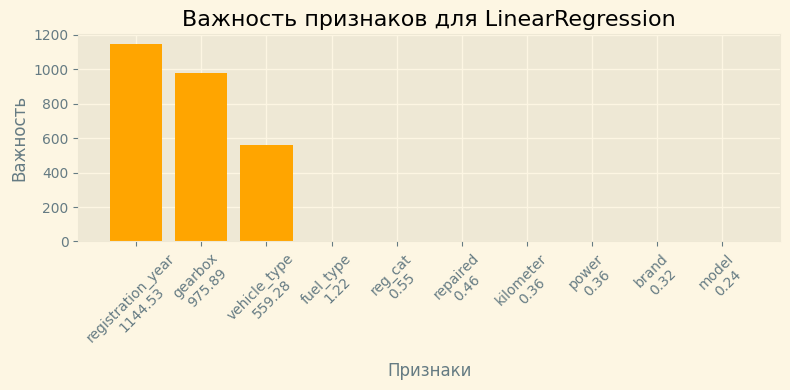


Model: RandomForest


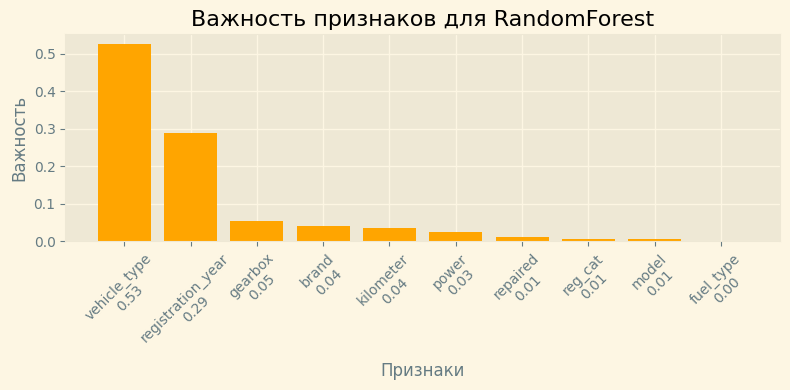


Model: LightGBM


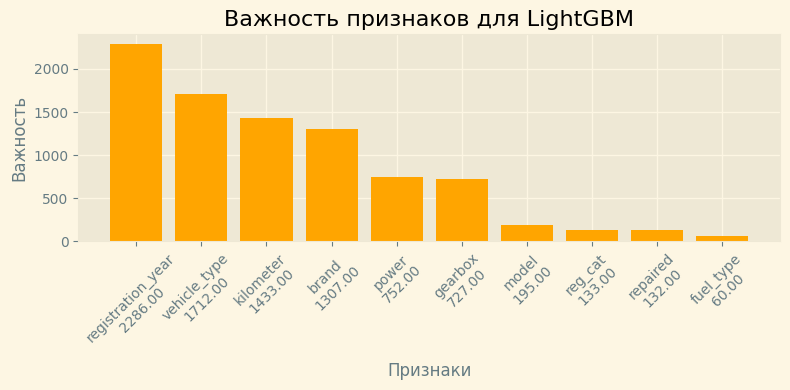


Model: CatBoost


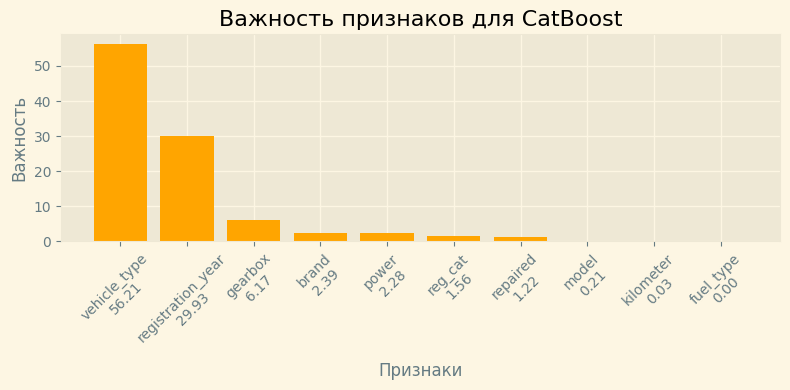

In [29]:
def plot_feature_importances(model_name, model):
    #Ввожу проверку на атрибут feature_importances_ из-за линейной регрес.
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    #Выбор коэф. для линейной регрес.
    elif hasattr(model, 'coef_'):
        importances = abs(model.coef_)

    #Список признаков из названий столбцов
    features = X_train.columns.tolist()

    #Сортировка по признаку и важности
    sorted_features = sorted(zip(features, importances), key=lambda x: abs(x[1]), reverse=True)

    #Список для значений важности
    sorted_importances = [x[1] for x in sorted_features]

    #График
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(sorted_importances)), sorted_importances, color='orange')
    plt.xticks(range(len(sorted_importances)), [f'{feature}\n{importance:.2f}' for feature, importance in sorted_features], rotation=45)
    plt.title(f'Важность признаков для {model_name}')
    plt.xlabel('Признаки')
    plt.ylabel('Важность')
    plt.tight_layout()
    plt.show()

#Цикл важности для каждой модели
for model_name, model_class in models:
    print(f"\nModel: {model_name}")
    plot_feature_importances(model_name, best_models[model_name])


<b>Комментарий к результатам обучения</b>

Несмотря на более точное значение *RMSE* у случайного леса, я отдам предпочтение *LightGBM*, данная модель быстрее обучается и опирается на болшьшее количество признаков в своих прогнозах

### Тестирование
<a id='14-bullet'></a>

In [30]:
#Выбор лучшей модели LightGBM
best_model = best_models['LightGBM']

#Предобработка
X_test_transformed = preprocessor.fit(X_test).transform(X_test)

import time
#Предсказание
start_time_test = time.time()
y_pred = best_model.predict(X_test_transformed)
end_time_test = time.time()

training_time_test = end_time_test - start_time_test

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"LightGBM RMSE на тестовых данных: {rmse:.5}")
print(f"Время предсказания LightGBM: {training_time_test:.4}")

LightGBM RMSE на тестовых данных: 1818.6
Время предсказания LightGBM: 0.08322


##Шаг 6. Общий вывод

<b>Финальный вывод</b>

- В ходе исследования предобработал и очистил данные

- Обучено 4 модели (*CatBoost*, *LightGBM*, *RandomForest*, *LinearRegression*)

- Наихудшую точность показала модель *CatBoost*, и среднее время обучаемости

- Лучше всего под запросы заказчика подходит *LightGBM*, показывая почти наибольшую точность и оптимальное время обучения, конкуренцию в точности состовляет дерево решений, но имеет проигрышное время обучения

- Метрики потенциально можно улучшить, воспользовавшись сэмплированием категориальных значений (почти во всех столбцах дисбаланс классов)
